# Task 2 Multi Class Classification

## PLAN

Further break each heartbeat class into multiple classes (from task 1):
- N: Non-ectopic beats (normal beats)
- S: Supraventricular ectopic beats
- V: Ventricle ectopic beats
- F: Fusion beats
- Q: Unknown beats

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

## ANALYZE

### 2.1 Import, Load and Examine

In [28]:
# Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.ensemble import GradientBoostingClassifier  # GBM
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.tree import DecisionTreeClassifier  # Decision Trees
from sklearn.svm import SVC # SVC
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors (KNN)
from xgboost import XGBClassifier  # XGBoost
from lightgbm import LGBMClassifier  # LightGBM

# SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

from scipy.stats import randint, uniform

# Evaluate
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, recall_score, f1_score, \
precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Save model
import pickle

# Ignore warning
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
plt.style.use('ggplot')

In [29]:
df = pd.read_csv("ecg_dataset/mitbih_train.csv", header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


### 2.2 Data Cleaning

In [31]:
# Check missing values
df.isnull().sum().sum

<bound method Series.sum of 0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64>

In [32]:
# Check duplicates
df.duplicated().sum()

np.int64(0)

### 2.3 Exploratory Data Analysis (EDA)

In [33]:
# Get distribution of different class
# Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
df[187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

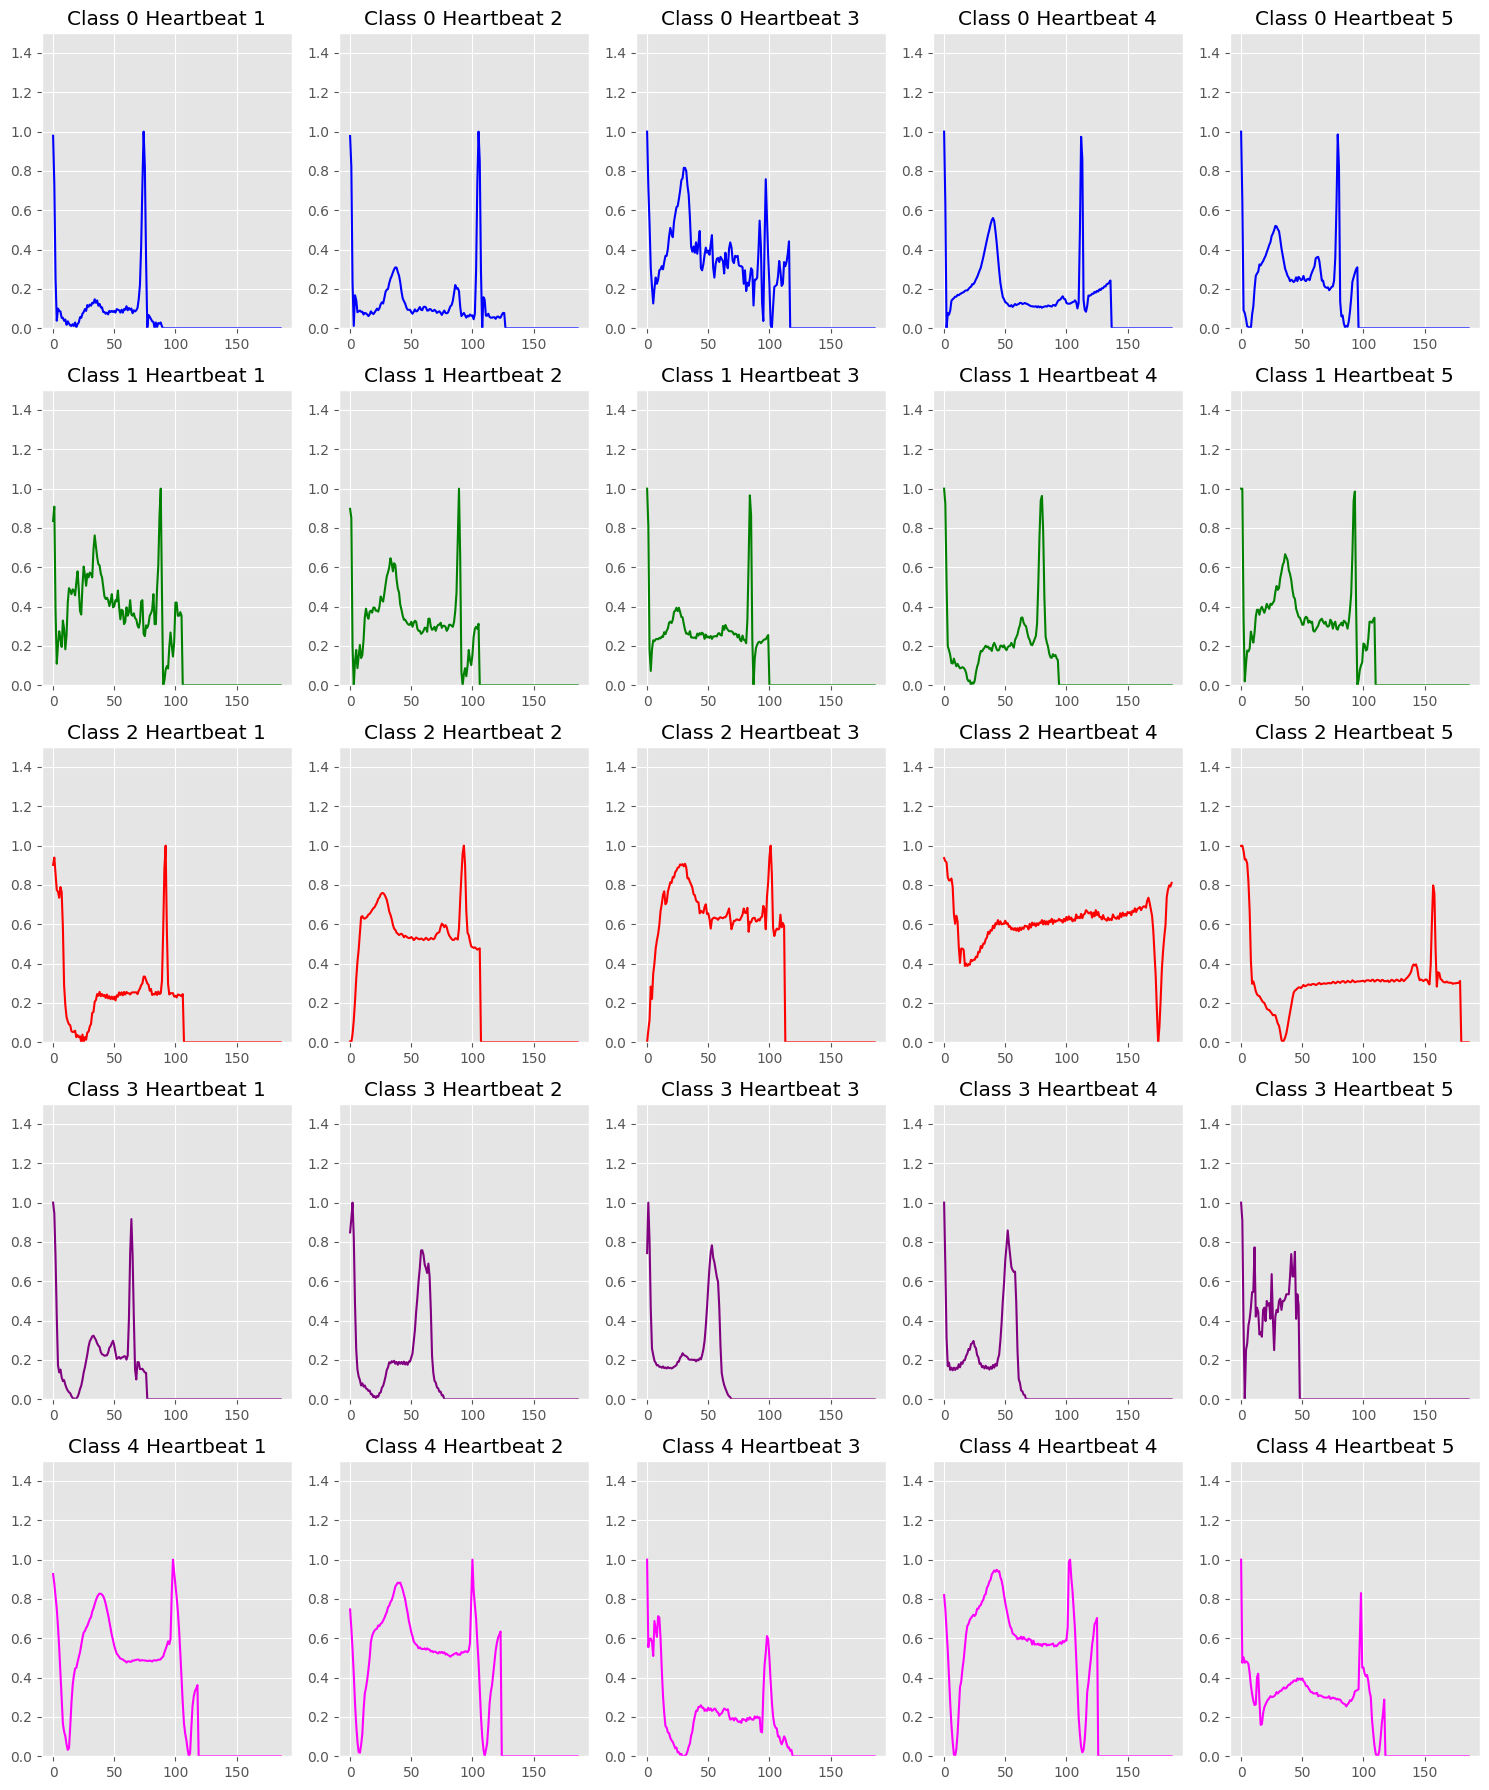

In [34]:
# Select 5 random rows from each class (0-4)
samples = pd.concat([df[df[187] == i].sample(5) for i in range(5)])

colors = ['blue', 'green', 'red', 'purple', 'magenta']

# Create a figure with multiple subplots
plt.figure(figsize=(15, 18))

# Plotting the selected heartbeats with different colors for each class
for i, row in enumerate(samples.iterrows()):
    class_label = int(row[1][187])  
    plt.subplot(5, 5, i + 1) 
    plt.plot(row[1][:-1], color=colors[class_label]) 
    plt.title(f'Class {class_label} Heartbeat {i % 5 + 1}')
    plt.ylim(0, 1.5)
    plt.tight_layout()

plt.show()

## 

### 3.1 Data Processing

In [35]:
# Set x and y
x = df.drop(187, axis=1)
y = df[187].values

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

### 3.2 Explore Distinct Model

In [36]:
# Initialize the models
models = {
    "rf": RandomForestClassifier(random_state=1),
    "svm": SVC(random_state=1),
    "knn": KNeighborsClassifier(),
    "xgb": XGBClassifier(random_state=1),
    "lgbm": LGBMClassifier(random_state=1)
}

predictions = {} 
scores = {}

# Loop through the models dictionary
for name, model in models.items():
    model.fit(x_train, y_train)
    predictions[f"y_pred_{name}"] = model.predict(x_test)  # Save predictions
    scores[name] = model.score(x_test, y_test)  # Save scores
    
scores


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47490
[LightGBM] [Info] Number of data points in the train set: 61287, number of used features: 187
[LightGBM] [Info] Start training from score -0.187967
[LightGBM] [Info] Start training from score -3.662583
[LightGBM] [Info] Start training from score -2.726029
[LightGBM] [Info] Start training from score -4.914075
[LightGBM] [Info] Start training from score -2.619075


{'rf': 0.9723988274260479,
 'svm': 0.9651273460996688,
 'knn': 0.9718658392659991,
 'xgb': 0.979670308752427,
 'lgbm': 0.9770434385350439}

### 3.3 Evaluate Model

#### 3.3.1 Confusion Matrix

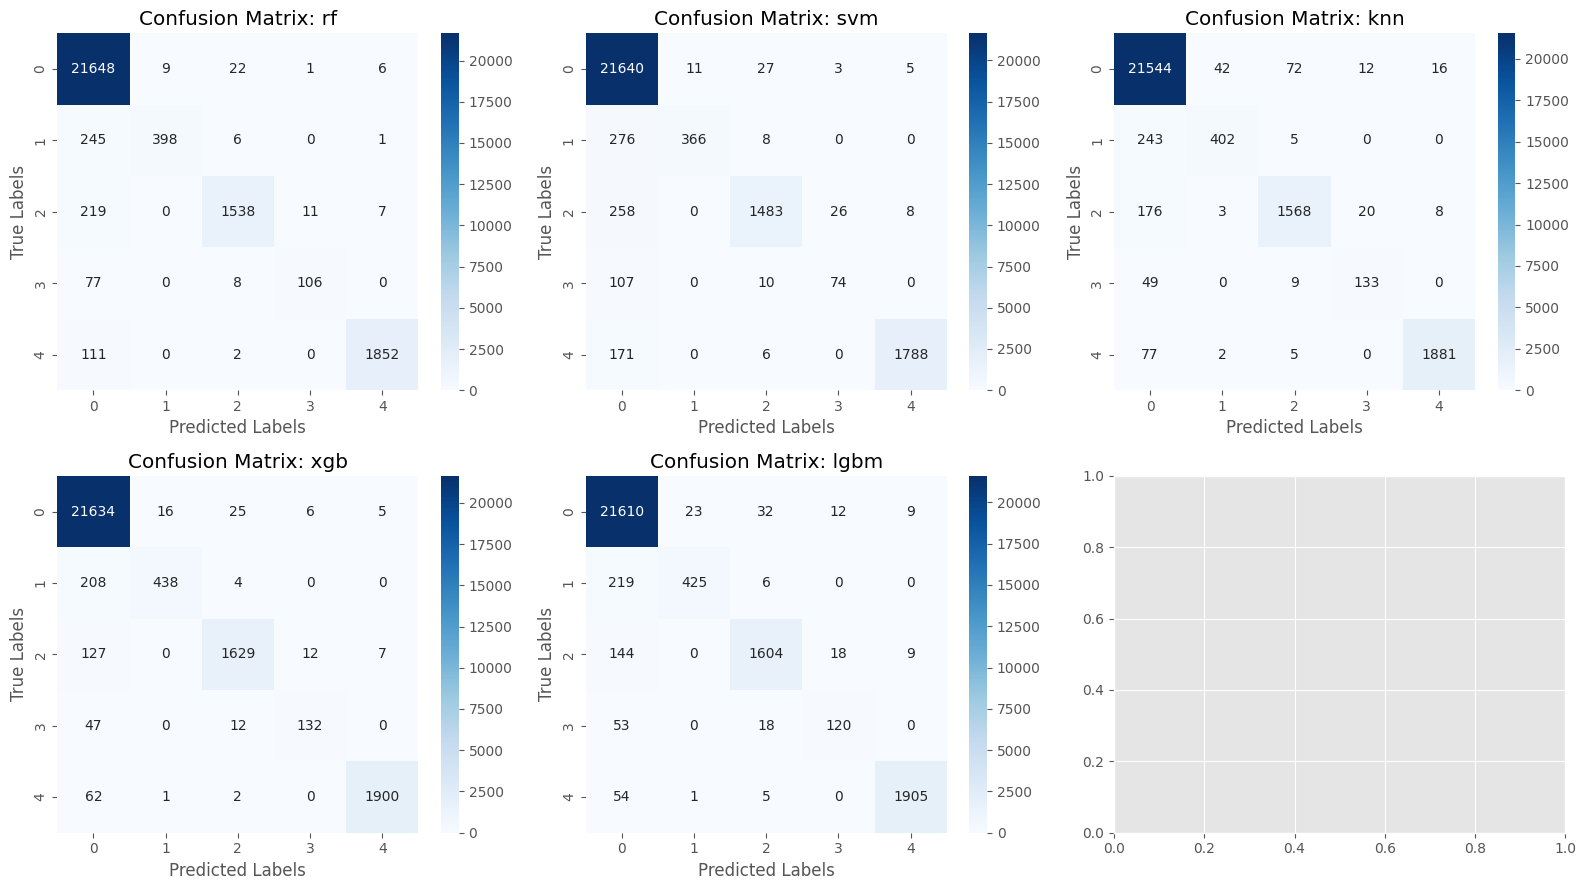

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))  
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, (name, model) in enumerate(models.items()):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, predictions[f"y_pred_{name}"])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])  # Use Blues color map
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


#### 3.3.2 Scores

In [38]:
# Metrics dictionary to store the scores
metrics = {}

# Calculate F1, Precision, Recall, AUC, and Accuracy
for name, model in models.items():
    y_pred = predictions[f"y_pred_{name}"]
    y_true = y_test  
    metrics[name] = {
        'f1': f1_score(y_true, y_pred, average='weighted'),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'accuracy': accuracy_score(y_true, y_pred)
    }
    if f"y_proba_{name}" in predictions:
        y_proba = predictions[f"y_proba_{name}"]
        metrics[name]['auc'] = roc_auc_score(y_true, y_proba)

# Print the calculated metrics for each model
for name, scores in metrics.items():
    print(f"Metrics for {name}:")
    for metric, value in scores.items():
        print(f"  {metric}: {round(value, 3)}")


Metrics for rf:
  f1: 0.971
  precision: 0.972
  recall: 0.972
  accuracy: 0.972
Metrics for svm:
  f1: 0.962
  precision: 0.965
  recall: 0.965
  accuracy: 0.965
Metrics for knn:
  f1: 0.971
  precision: 0.971
  recall: 0.972
  accuracy: 0.972
Metrics for xgb:
  f1: 0.979
  precision: 0.979
  recall: 0.98
  accuracy: 0.98
Metrics for lgbm:
  f1: 0.976
  precision: 0.976
  recall: 0.977
  accuracy: 0.977


From the Confusion Matrix and Muti-Scores, XGBoost is considered best model again.


In [39]:
# Save the best model
best_model = models['xgb']
filename = 'model_t2.pkl'
pickle.dump(best_model, open(filename, 'wb'))

### 3.4 Model with SMOTE

Now we know XGBoost is best model, but based on Confusion Matrix, we are trying to reduce some number using SMOTE.

In [40]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Check the class distribution after SMOTE
print(pd.Series(y_train_smote).value_counts())

0.0    50785
2.0    50785
1.0    50785
4.0    50785
3.0    50785
Name: count, dtype: int64


In [41]:
# Train the model with SMOTE data
model = XGBClassifier(random_state=1)
model.fit(x_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [42]:
# Predict and Evaluate
predictions = model.predict(x_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[21221   283    92    60    30]
 [  129   517     3     1     0]
 [   66     3  1686    14     6]
 [   14     0    14   163     0]
 [   28     4     9     1  1923]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     21686
         1.0       0.64      0.80      0.71       650
         2.0       0.93      0.95      0.94      1775
         3.0       0.68      0.85      0.76       191
         4.0       0.98      0.98      0.98      1965

    accuracy                           0.97     26267
   macro avg       0.85      0.91      0.87     26267
weighted avg       0.97      0.97      0.97     26267



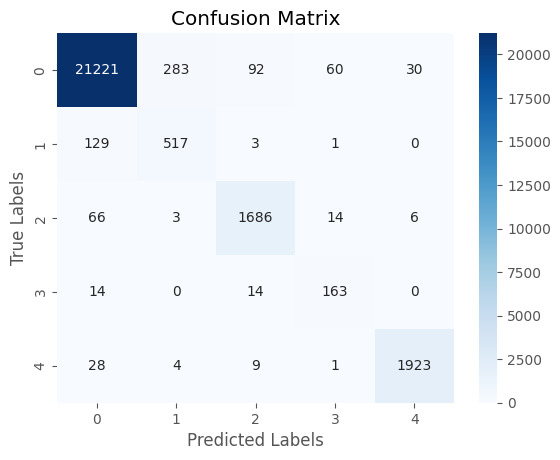

In [43]:
# Visualization

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
# plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [44]:
# save the model
filename = 'model_t2_smote.pkl'
pickle.dump(model, open(filename, 'wb'))



### 3.5 Apply on Test Dataset

#### 3.5.1 Import/Prepare

In [45]:
# Input test set but without the last column
df_test = pd.read_csv("ecg_dataset/mitbih_test.csv", header=None, usecols=range(187))
# df_test = pd.read_csv("ecg_dataset/mitbih_test.csv", header=None)
df_test

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df_test_answer = pd.read_csv("ecg_dataset/mitbih_test.csv", header=None, usecols=[187])
df_test_answer

,187
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
21887,4.0
21888,4.0
21889,4.0
21890,4.0


#### 3.5.2 Predict

In [47]:
# Load the model
loaded_model = pickle.load(open("model_t2.pkl", 'rb'))

# Make predictions
y_pred = loaded_model.predict(df_test)
y_pred


array([0, 0, 0, ..., 4, 4, 4])

In [48]:
# Compare the predictions with the actual labels
accuracy_score(df_test_answer, y_pred)

0.978850721724831

#### 3.5.3 Predict with SMOTE

In [49]:
# Load the model
loaded_model = pickle.load(open("model_t2_smote.pkl", 'rb'))

# Make predictions
y_pred_smote = loaded_model.predict(df_test)
y_pred_smote

array([0, 0, 0, ..., 4, 4, 4])

In [50]:
# Compare the predictions with the actual labels
accuracy_score(df_test_answer, y_pred_smote)

0.9691211401425178

## CONSLUSION

Based on the result, we get an accuracy of 97.88% on test dataset.